In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Read and explore the given dataset. 

In [2]:
df = pd.read_csv('ratings_Electronics.csv')
df.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [3]:
df.shape

(7824481, 4)

In [4]:
df.columns = ['userid','productid','ratings','timestamp']

In [5]:
df.head()

,userid,productid,ratings,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [6]:
df.shape

(7824481, 4)

In [7]:
df.drop('timestamp', inplace = True, axis = 1) #this parameter is not required in Recommender System

In [8]:
df.isnull().sum()

userid       0
productid    0
ratings      0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ratings,7824481.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


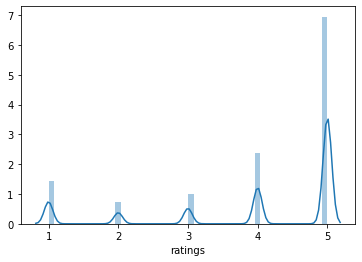

In [11]:
sns.distplot(df['ratings'])

# 2) Take a subset of the dataset to make it less sparse/ denser.

In [12]:
a = pd.DataFrame(df.groupby('userid')['productid'].count())
a.head()

,productid
userid,
A00000262KYZUE4J55XGL,1
A000063614T1OE0BUSKUT,2
A00009182QVLSWIGHLS1B,1
A00009661LC9LQPGKJ24G,1
A00010809P09NUU6ZP6H,1


In [13]:
b = a[a['productid']>=50]   #we select those users who have rated more than 50 products

In [14]:
b.head()

,productid
userid,
A100UD67AHFODS,116
A100WO06OQR8BQ,132
A105S56ODHGJEK,68
A105TOJ6LTVMBG,71
A10AFVU66A79Y1,65


In [15]:
df_final = pd.merge(df, b, on = 'userid')

In [16]:
df_final.head()

,userid,productid_x,ratings,productid_y
0,A3BY5KCNQZXV5U,0594451647,5.0,50
1,A3BY5KCNQZXV5U,B00000JD4V,4.0,50
2,A3BY5KCNQZXV5U,B000063574,5.0,50
3,A3BY5KCNQZXV5U,B0000CDJP8,5.0,50
4,A3BY5KCNQZXV5U,B0007Y794O,5.0,50


In [17]:
df_final.isnull().sum()

userid         0
productid_x    0
ratings        0
productid_y    0
dtype: int64

In [18]:
df_final.drop('productid_y', axis = 1, inplace = True)

# 3. Build Popularity Recommender model

# Popularity recommendation System 1

In [41]:
df_final.groupby('productid_x')['ratings'].count().sort_values(ascending = False)

productid_x
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
             ... 
B004AB1OS2      1
B004AB02IA      1
B004AAZXQM      1
B004AAPKTW      1
0594451647      1
Name: ratings, Length: 48190, dtype: int64

In [42]:
pop_1 = pd.DataFrame(df_final.groupby('productid_x')['ratings'].mean().sort_values(ascending = False))

In [43]:
pop_1.head()

,ratings
productid_x,
B00LKG1MC8,5.0
B002QUZM3M,5.0
B002QWNZHU,5.0
B002QXZPFE,5.0
B002R0DWNS,5.0


In [44]:
pop_1['count']= pd.DataFrame(df_final.groupby('productid_x')['ratings'].count())

In [45]:
pop_1[pop_1['count']==pop_1['count'].max()]

,ratings,count
productid_x,,
B0088CJT4U,4.218447,206


In [46]:
pop_1['count'].max()

206

In [47]:
pop_1[pop_1['count']== 206]    

,ratings,count
productid_x,,
B0088CJT4U,4.218447,206


In [48]:
pop_1.head()   #Top 5 recommendations of this model

,ratings,count
productid_x,,
B00LKG1MC8,5.0,1
B002QUZM3M,5.0,1
B002QWNZHU,5.0,1
B002QXZPFE,5.0,3
B002R0DWNS,5.0,1


# Popularity recommender System 2

In [49]:
pop_2 = pd.DataFrame(df_final.groupby('productid_x')['ratings'].count().sort_values(ascending = False))

In [50]:
pop_2.head()

,ratings
productid_x,
B0088CJT4U,206
B003ES5ZUU,184
B000N99BBC,167
B007WTAJTO,164
B00829TIEK,149


In [51]:
pop_2['rating_avg']= pd.DataFrame(df_final.groupby('productid_x')['ratings'].mean())

In [52]:
pop_2.head()    #5 most recommended movies by pop_2

,ratings,rating_avg
productid_x,,
B0088CJT4U,206,4.218447
B003ES5ZUU,184,4.864130
B000N99BBC,167,4.772455
B007WTAJTO,164,4.701220
B00829TIEK,149,4.436242


# 5 Build Collaborative Filtering model

# User- User Collaborative System

In [53]:
from surprise import KNNWithMeans
from surprise import accuracy
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise import SVD
from collections import defaultdict


In [54]:
reader = Reader(rating_scale=(1, 5))

In [55]:
data = Dataset.load_from_df(df_final, reader = reader )

# 4 Split the data randomly into a train and test dataset. 


In [67]:
trainset, testset = train_test_split(data, test_size = 0.3)

In [68]:
algo = KNNWithMeans(k=50, sim_options={'name': 'cosine', 'user_based': True})
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [69]:
df_final.head()

,userid,productid_x,ratings
0,A3BY5KCNQZXV5U,0594451647,5.0
1,A3BY5KCNQZXV5U,B00000JD4V,4.0
2,A3BY5KCNQZXV5U,B000063574,5.0
3,A3BY5KCNQZXV5U,B0000CDJP8,5.0
4,A3BY5KCNQZXV5U,B0007Y794O,5.0


In [70]:
uid = 'A3BY5KCNQZXV5U'
mov_id = 'B00000JD4V'

In [60]:
pred = algo.predict(uid, mov_id, verbose = True)

user: A3BY5KCNQZXV5U item: B00000JD4V r_ui = None   est = 4.04   {'actual_k': 3, 'was_impossible': False}


In [61]:
test_pred = algo.test(testset)

In [62]:
test_pred

[Prediction(uid='A23NSKTMSPPBTR', iid='B00005A1K1', r_ui=3.0, est=3.8393009377664105, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AZOK5STV85FBJ', iid='B003B01AHS', r_ui=5.0, est=4.263071876879774, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2MJ8OL2FYN7CW', iid='B004YIZVW6', r_ui=4.0, est=2.95670302336969, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A20WUUD9EDWY4N', iid='B007VGGIB6', r_ui=4.0, est=4.8921568627450975, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A3Q4TYJVAM4IRM', iid='B001DNUPQW', r_ui=5.0, est=4.263071876879774, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A74UT8IQCM0I2', iid='B006ZZQ5EY', r_ui=5.0, est=4.72093023255814, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2BLFCOPSMBOZ9', iid='B000XFVZ5G', r_ui=5.0, est=4.810311870955065, details={'actual_k': 2, 'was_impossible': False}),


# 7) Get top - K ( K = 5) recommendations. Since our goal is to recommend newproducts to each user based on his/her habits, we will recommend 5 new products. ( 10 marks)

In [63]:
def gettop(test_pred, n = 5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in test_pred:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid]= user_ratings[:n]
        
    return top_n    
    
    
    

In [64]:
top_n = gettop(test_pred, n = 5)
top_n

defaultdict(list,
            {'A23NSKTMSPPBTR': [('B000AM8SK2', 4.47718162195498),
              ('B00BQ4F9ZA', 4.390207792708685),
              ('B000LRMS66', 4.338411894466221),
              ('B00HUTAO5K', 4.305224403927069),
              ('B00546JKJC', 4.273923114886562)],
             'AZOK5STV85FBJ': [('B001TH7GUU', 5),
              ('B005PQTYHE', 4.925),
              ('B0002L5R78', 4.921631203578617),
              ('B0007OWNYA', 4.675),
              ('B000XZ1AY2', 4.675)],
             'A2MJ8OL2FYN7CW': [('B00028OP2Y', 5),
              ('B006OBGEHW', 5),
              ('B00BUMXO3C', 5),
              ('B00CELZD8C', 4.976343788796669),
              ('B004YIZXEC', 4.945454545454545)],
             'A20WUUD9EDWY4N': [('B00BXA7N6A', 5),
              ('B007R9M6PO', 5),
              ('B0012Y2LLE', 5),
              ('B0036RH93K', 4.905762304921969),
              ('B007VGGIB6', 4.8921568627450975)],
             'A3Q4TYJVAM4IRM': [('B000JDJJ82', 5),
              ('B0010Z28

In [65]:
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid,user_ratings) in user_ratings])

A23NSKTMSPPBTR ['B000AM8SK2', 'B00BQ4F9ZA', 'B000LRMS66', 'B00HUTAO5K', 'B00546JKJC']
AZOK5STV85FBJ ['B001TH7GUU', 'B005PQTYHE', 'B0002L5R78', 'B0007OWNYA', 'B000XZ1AY2']
A2MJ8OL2FYN7CW ['B00028OP2Y', 'B006OBGEHW', 'B00BUMXO3C', 'B00CELZD8C', 'B004YIZXEC']
A20WUUD9EDWY4N ['B00BXA7N6A', 'B007R9M6PO', 'B0012Y2LLE', 'B0036RH93K', 'B007VGGIB6']
A3Q4TYJVAM4IRM ['B000JDJJ82', 'B0010Z28XG', 'B001CIVDU0', 'B0036AWR8E', 'B001SER48S']
A74UT8IQCM0I2 ['B008RM235I', 'B009DMFOVG', 'B008RVJJZG', 'B006ZZQ5EY', 'B00152QN08']
A2BLFCOPSMBOZ9 ['B001GDLYAU', 'B004SD1ZPY', 'B001TH7GUA', 'B004G8QO8E', 'B00GJYJFKM']
A2Q7OJTVPIO2XH ['B005OHRK2U', 'B00BQ8V0EA', 'B0043WJRRS', 'B00EQ07PG2', 'B005FQSXFI']
AKT8TGIT6VVZ5 ['B00BOHNYTW', 'B00006I5DQ', 'B0009R3N9E', 'B00009R6WO', 'B00009XVBU']
A2JWF9IG8PJAOA ['B001C4ETU0', 'B000VX6XL6', 'B002ZCXJZE', 'B008RJZQSW', 'B006MRAVFE']
A2ZRG5NOFZ47RK ['B0053FR9FQ', 'B0010CEWDI', 'B0018BTPLK', 'B0046TDJJK', 'B0057GO0BC']
A1F5O1USOUOOXI ['B00D5Q75RC', 'B008O2HW8O', 'B0099SMFP2',

A1PAGHECG401K1 ['B00395ZQMK', 'B006GWO5WK', 'B0092KRAVQ', 'B000BQ7GW8', 'B003ZTWYXY']
A3O5ASFUXC32UA ['B0002WT6RY', 'B0000BZL1P', 'B0000BZLBA', 'B005IY2OD4', 'B00BQ8TZT2']
A2WDCAMKCCP1UR ['B004V9AMI6', 'B00775E034', 'B006HFVYJ8', 'B005CUVOD0', 'B002NEWGSK']
A3BI8BKIHESDNQ ['B000233WJ6', 'B00005U21H', 'B0009ON12G', 'B0057XC2X8', 'B00752NJMC']
A3E68EBGXTWDNP ['B00005LEN4', 'B00079SWNQ', 'B001EK5712', 'B000GHED96', 'B000FKYQFA']
AA8RBTN3J2F5H ['B000V1PAWQ', 'B004CADY9I', 'B005LJQMCK', 'B005LS2J14', 'B00004ZCDD']
AW3LX47IHPFRL ['B0002UBDDG', 'B00AA6OVAO', 'B008DZ2YT4', 'B000RE7RS2', 'B005MECX5Y']
A35C2IVVQR1HTK ['B004RORMF6', 'B00AAIPT76', 'B0012Y6HC8', 'B002IO2UM2', 'B0047XUQMI']
A1BZIM4WGZ6DZP ['B0035ERKYW', 'B001IEXU68', 'B005GJC01C', 'B003MVZ60S', 'B0001FTVEA']
AFFVUZEGP1FDQ ['B001TH7GT6', 'B005ARWDVW', 'B0082E9K7U', 'B003FG7IG0', 'B005NHTG6O']
A3SRDVCD2ATIIS ['B002WE4HE2', 'B000SMVQK8', 'B00008NJEP', 'B00385XUG0', 'B001WHQ9C8']
A2IIAQ7VVAHXTD ['B001TH7T2U', 'B000U5TUWE', 'B00316263Y',

# 6) Evaluate Model performance

In [66]:
print("User-based Model : Test Set: root mean squared error")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set: root mean squared error
RMSE: 1.0624


1.0623902192921562

In [31]:
print("User-based Model : Test Set:  mean squared error")
accuracy.mse(test_pred, verbose = True)

User-based Model : Test Set:  mean squared error
MSE: 1.1196


1.1195531493952746

In [32]:
print("User-based Model : Test Set:  mean absolute error")
accuracy.mae(test_pred, verbose= True)

User-based Model : Test Set:  mean absolute error
MAE:  0.7661


0.7661007244975705

# 8) Summarise your insights.

# So user user collaborative system is Best among all 4 recommender systems